In [1]:
#import packages
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from bisect import bisect

In [46]:
# plot overlaid histogram of features in column for each class
def df_hist(column):
    class0 = df.loc[df['class'] == 0, [column]].values
    class1 = df.loc[df['class'] == 1, [column]].values
    nr_bins = 20
    bin_edges = np.histogram(np.r_[class0, class1], bins=nr_bins)[1]
    width = 0.5 * (bin_edges[1] - bin_edges[0])
    hist0 = np.histogram(class0, bin_edges)[0]
    hist1 = np.histogram(class1, bin_edges)[0]
    plt.bar(bin_edges[0:nr_bins], hist0.astype(float)/sum(hist0), width, alpha=0.5, color='r', label='0')
    plt.bar(bin_edges[0:nr_bins], hist1.astype(float)/sum(hist1), width, align='center', alpha=0.5, color='g', label='1')
    plt.legend(loc='upper right')
    plt.show()

In [2]:
#import fraud data
url = 'Fraud_Data.csv'
df = pd.read_csv(url)
nr_datarows, nr_datacols = df.shape
print 'nr_datarows = %s, nr_datacols = %s' % (nr_datarows, nr_datacols)
#import ip address to country data
url = 'IpAddress_to_Country.csv'
ipdata = pd.read_csv(url)
ipdata = ipdata.as_matrix()
nr_ipdatarows = ipdata.shape[0]
print 'nr_ipdatarows = %s' % nr_ipdatarows
ip_low = ipdata[:,0].astype(float)
ip_hi = ipdata[:,1].astype(float)
ip_low = np.r_[ip_low, ip_hi[-1]]
ip_country = ipdata[:,2].astype(str)
# check sorted
print 'It is %r that ipdata is sorted' % all(ip_low[i] < ip_low[i+1] and ip_hi[i] < ip_hi[i+1] for i in range(nr_ipdatarows - 1))
print 'It is %r that user_id differs for every row' % (len(df['user_id']) == len(set(df['user_id'])))
df = df.drop('user_id', axis=1)
set_devices = set(df['device_id'])
print 'nr_devices = %r' % len(set_devices)
set_ip = set(df['ip_address'])
print 'nr_ip = %r' % len(set_ip)
print 'nr_non_fraud = %r' % sum(df['class'] == 0)
print 'nr_fraud = %r' % sum(df['class'])
print 'P(fraud) = %r' % (float(sum(df['class']))/nr_datarows)

# add country to table
# bisect provides *major* speed improvement
country = []
for ip in df['ip_address']:
    ip_row = bisect(ip_low, ip) - 1
    if ip_row == nr_ipdatarows or ip > ip_hi[ip_row]:
        country.append('None')
    else:
        country.append(ip_country[ip_row])
df['country'] = country

#create new features
#time since signup
df['time'] = (pd.to_datetime(df['purchase_time'])-pd.to_datetime(df['signup_time']))/np.timedelta64(1, 'h')
df = df.drop('purchase_time', axis=1)
df = df.drop('signup_time', axis=1)

# nr_users per device
nr_device_users = {}
for index, row in df.iterrows():
    dev_id = row['device_id']
    if dev_id not in nr_device_users:
        nr_device_users[dev_id] = 0
    nr_device_users[dev_id] += 1
nr_users = []
for dev_id in df['device_id']:
    nr_users.append(nr_device_users[dev_id])
df['nr_users'] = nr_users
nr_device_users.clear()

# drop variables not used for classification
df = df.drop('device_id', axis=1)
df = df.drop('source', axis=1)
df = df.drop('browser', axis=1)
df = df.drop('ip_address', axis=1)

# change categorical to integer
df['sex'] = df['sex'].astype('category')
df['sex'] = df['sex'].cat.codes
df['country'] = df['country'].astype('category')
df['country'] = df['country'].cat.codes

print df.dtypes

df.head()

nr_datarows = 151112, nr_datacols = 11
nr_ipdatarows = 138846
It is True that ipdata is sorted
It is True that user_id differs for every row
nr_devices = 137956
nr_ip = 143512
nr_non_fraud = 136961
nr_fraud = 14151
P(fraud) = 0.09364577267192546
purchase_value      int64
sex                  int8
age                 int64
class               int64
country             int16
time              float64
nr_users            int64
dtype: object


,purchase_value,sex,age,class,country,time,nr_users
0,34,1,39,0,84,1251.856111,1
1,16,0,53,0,172,4.984444,1
2,15,1,53,1,172,0.000278,12
3,44,1,41,0,124,136.690278,1
4,39,1,45,0,172,1211.516944,1


In [3]:
df.groupby('class').mean()

,purchase_value,sex,age,country,time,nr_users
class,,,,,,
0,36.929418,0.583078,33.122356,122.144800,1441.994052,1.120071
1,36.993004,0.596000,33.318281,122.557628,673.289542,7.145926


# 'time' and 'nr_users' look like good features to discrimnate fraud vs non-fraud

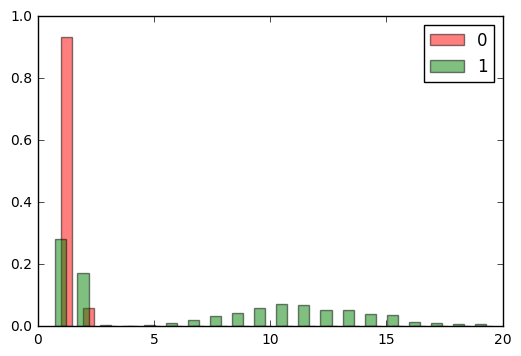

In [47]:
df_hist('nr_users')

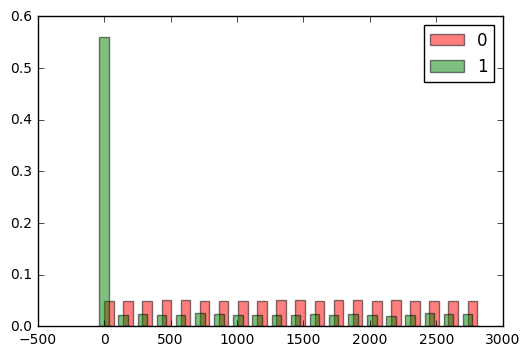

In [48]:
df_hist('time')